In [17]:
import torch
import torch.nn.functional as F
from torch.optim import Adam
from torch.nn import Linear, MSELoss, Sequential, Sigmoid, Softmax, ReLU, LeakyReLU, Module
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.interpolate import make_interp_spline, BSpline

In [18]:
df = pd.read_csv('io-bytes-control-group.csv')
df

,vms,bytesIn,bytesOut
0,10,175738,256359
1,10,172706,252652
2,20,1236708,1543554
3,20,1297012,1617267
4,30,3313888,3832667
5,30,3386892,3897552
6,40,8850857,9529250
7,40,7319968,8280876
8,50,10200611,11349472
9,50,10483388,11593969


In [19]:
df.corr()

,vms,bytesIn,bytesOut
vms,1.000000,0.972422,0.976842
bytesIn,0.972422,1.000000,0.999652
bytesOut,0.976842,0.999652,1.000000


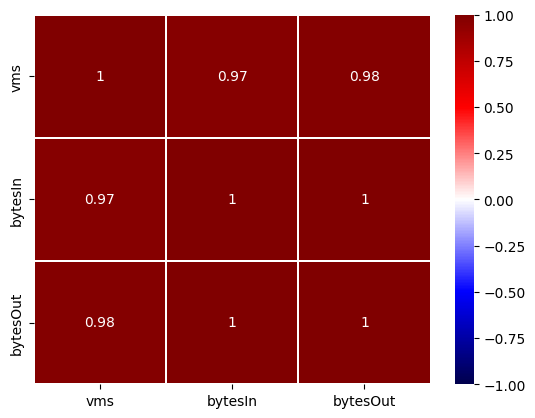

In [20]:
# plt.figure(figsize=(10,10))
sb.heatmap( df.corr(), vmin=-1, vmax=1, annot=True, linewidths=0.2, cmap='seismic' )
plt.show()

In [21]:
df = df.dropna() # drop all rows that have NAN/none
df['sum'] = (df['bytesIn']+df['bytesOut'])/1024
df.insert(0, "squared_vms", df['vms']**2, True)
df

,squared_vms,vms,bytesIn,bytesOut,sum
0,100,10,175738,256359,421.969727
1,100,10,172706,252652,415.388672
2,400,20,1236708,1543554,2715.099609
3,400,20,1297012,1617267,2845.975586
4,900,30,3313888,3832667,6979.057617
5,900,30,3386892,3897552,7113.714844
6,1600,40,8850857,9529250,17949.323242
7,1600,40,7319968,8280876,15235.199219
8,2500,50,10200611,11349472,21045.002930
9,2500,50,10483388,11593969,21559.918945


In [22]:
x_data = df.iloc[:,:2].values # 0, 1 열 (x^2 + x)
y_data = df.iloc[:,[-1]].values  # 마지막 열만
print(x_data.shape)

(10, 2)


In [23]:
scaleF = MinMaxScaler()
x_dataN = scaleF.fit_transform( x_data )

scaleL = MinMaxScaler()
y_dataN = scaleL.fit_transform( y_data )
y_dataN.shape

x_dataN

array([[0.        , 0.        ],
       [0.        , 0.        ],
       [0.125     , 0.25      ],
       [0.125     , 0.25      ],
       [0.33333333, 0.5       ],
       [0.33333333, 0.5       ],
       [0.625     , 0.75      ],
       [0.625     , 0.75      ],
       [1.        , 1.        ],
       [1.        , 1.        ]])

In [24]:
x = torch.FloatTensor(x_dataN) # 특성 데이터
y = torch.FloatTensor(y_dataN) # 라벨

In [25]:
class ExpModel(Module):
    def __init__(self):
        super().__init__()
        self.fc1 = Linear(2,1)
    
    def forward(self, x):        
        x = self.fc1(x)
        
        return x       
        

In [26]:
# model = Sequential()
# model.add_module('nn1', Linear(1,1))
model = ExpModel()
list(model.parameters())

[Parameter containing:
 tensor([[0.6488, 0.1607]], requires_grad=True),
 Parameter containing:
 tensor([0.4585], requires_grad=True)]

In [27]:
loss_fn = MSELoss()
optimizer = Adam(model.parameters())

In [28]:
hist = []
for step in range(3000):
    optimizer.zero_grad()
    hx = model.forward(x) # w*x+b # hx = model(x)
    cost = loss_fn(hx, y)
    cost.backward()
    optimizer.step()
    if step % 100 == 0:
        print(step, cost.item())
    hist.append(cost.item())

0 0.15098603069782257
100 0.06819117814302444
200 0.044781189411878586
300 0.03388632833957672
400 0.025240769609808922
500 0.01841677539050579
600 0.013354979455471039
700 0.009807439520955086
800 0.007451297249644995
900 0.005967232398688793
1000 0.0050810882821679115
1100 0.0045799678191542625
1200 0.004311917815357447
1300 0.004176467191427946
1400 0.004111872985959053
1500 0.004082804080098867
1600 0.0040704174898564816
1700 0.004065359476953745
1800 0.004063301719725132
1900 0.004062382038682699
2000 0.004061862826347351
2100 0.00406147725880146
2200 0.00406112102791667
2300 0.004060768522322178
2400 0.004060415551066399
2500 0.004060060251504183
2600 0.004059703554958105
2700 0.0040593454614281654
2800 0.0040589869022369385
2900 0.004058629274368286


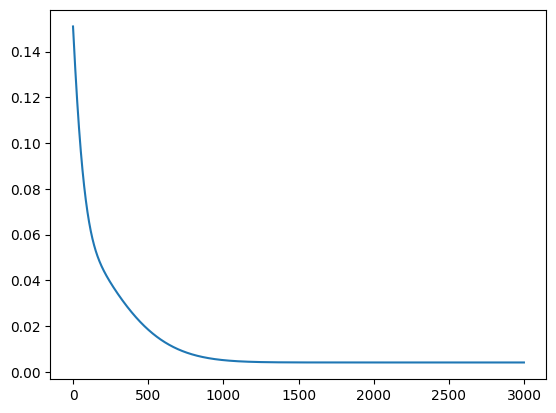

In [29]:
plt.plot(hist)
plt.show()

In [30]:
list(model.parameters())

[Parameter containing:
 tensor([[0.8427, 0.2078]], requires_grad=True),
 Parameter containing:
 tensor([-0.0193], requires_grad=True)]

In [31]:
# Dummy data to draw smooth graph
x_axis = np.linspace(1,50,50) # [ 1 , 2, 3, 4, ...., 50]
x_dummy = [[xval**2, xval] for xval in x_axis]
scaleF = MinMaxScaler()
x_dummyN = scaleF.fit_transform( x_dummy )

predN = model(torch.FloatTensor(x_dummyN)).detach().numpy()
pred = scaleL.inverse_transform(predN)
pred

array([[6.59360456e+00],
       [1.17675186e+02],
       [2.43017868e+02],
       [3.82621643e+02],
       [5.36486572e+02],
       [7.04612610e+02],
       [8.86999695e+02],
       [1.08364795e+03],
       [1.29455725e+03],
       [1.51972766e+03],
       [1.75915918e+03],
       [2.01285193e+03],
       [2.28080566e+03],
       [2.56302051e+03],
       [2.85949658e+03],
       [3.17023340e+03],
       [3.49523169e+03],
       [3.83449121e+03],
       [4.18801123e+03],
       [4.55579297e+03],
       [4.93783545e+03],
       [5.33413867e+03],
       [5.74470410e+03],
       [6.16953027e+03],
       [6.60861719e+03],
       [7.06196533e+03],
       [7.52957471e+03],
       [8.01144434e+03],
       [8.50757617e+03],
       [9.01796875e+03],
       [9.54262305e+03],
       [1.00815371e+04],
       [1.06347139e+04],
       [1.12021504e+04],
       [1.17838486e+04],
       [1.23798076e+04],
       [1.29900264e+04],
       [1.36145088e+04],
       [1.42532510e+04],
       [1.49062549e+04],


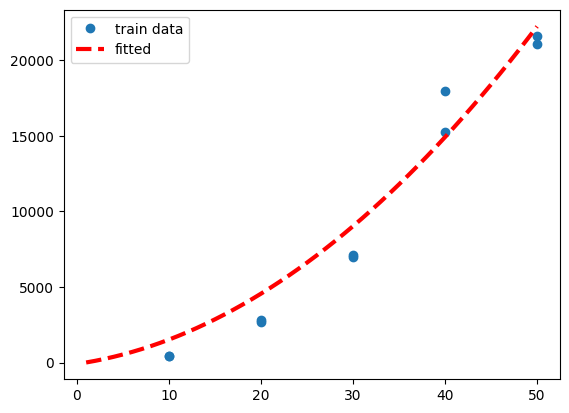

In [32]:
# plt.ylim([0, 25000])
plt.plot(x_data[:,[1]], y_data, 'o', label='train data')
# plt.scatter(x_data, y_data)
# plt.plot(x_data[:,1], np.exp(model(x).data.numpy()), '-r', linewidth=3, label='fitted') # r-- : Red, dashed line

plt.plot(x_axis, pred, 'r--', linewidth=3, label='fitted') # r-- : Red, dashed line
# plt.grid()
plt.legend()
plt.show()